In [90]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### Fit lifetime normalization

In [209]:
def get_current_data():
    # REPLACE WITH REAL DATA
    # SIMULATE NORMALIZATION WITH I^-1 (Touschek)
    N = 6000
    x = np.linspace(50, 3000, N)
    #y = 20*np.exp(-(x**1.2)*0.0005)
    y = 20*1/(2 + 0.001*x) # solution to y' = -k y**2, ODE for Touschek lifetime, with generic params
    y = y + np.random.normal(0, 0.001, N)
    return x,y 

In [228]:
x,y = get_current_data()
df = pd.DataFrame.from_dict({'x':x,'y':y},'columns')
df.head(5)

,x,y
0,50.000000,9.757215
1,50.491749,9.753576
2,50.983497,9.752946
3,51.475246,9.749322
4,51.966994,9.746653


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


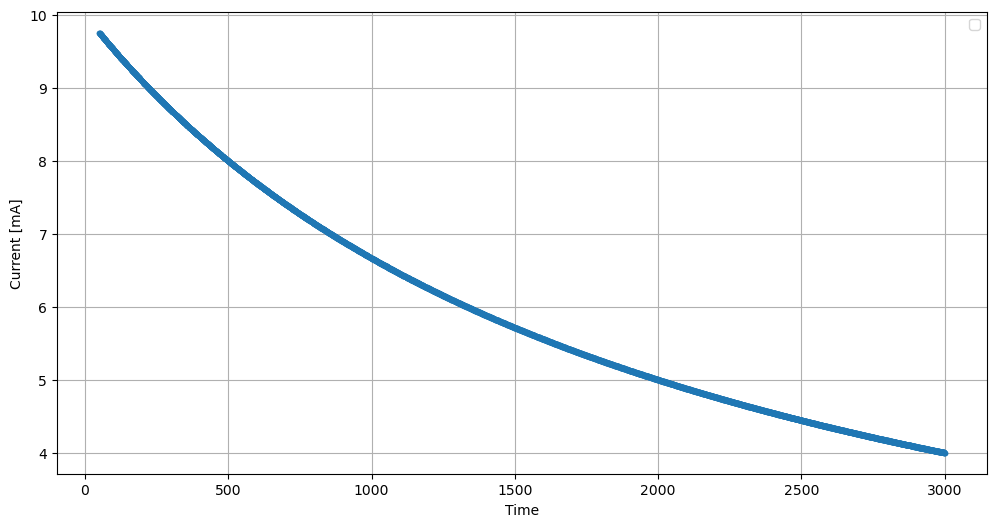

In [211]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(x,y,marker='.')
ax.set_xlabel('Time')
ax.set_ylabel('Current [mA]')
ax.grid()

In [212]:
import sklearn.linear_model as lm

def get_data_around_t(x,y,start,end):
    xs = (x > start) & (x < end)
    return x[xs], y[xs]

def slope(data_array):
    X = data_array[:, 0].reshape(-1, 1)
    #X = X - X[0,0]
    y = data_array[:, 1].reshape(-1, 1)
    linear_model = lm.LinearRegression()
    model = linear_model.fit(X, y)
    slope = model.coef_[0]
    return slope, model

In [213]:
window = 30
invseconds_to_invhours = 60 * 60
x_start = x[0]
data = []
while x_start+window < x[-1]:
    xl, yl = get_data_around_t(x,y,x_start,x_start+window)
    s,m = slope(np.hstack([xl[:,None], yl[:,None]]))
    avg_current = yl.mean()
    data.append({'s':1/(-s*invseconds_to_invhours/avg_current),
                 'avg_c': avg_current,
                 'jitter_s': np.std(yl - xl*s - m.intercept_[0]),
                 'sc':1/(-s*invseconds_to_invhours/avg_current)/avg_current*28,
                 't':xl.mean()
    })
    x_start += window//4
df_data = pd.DataFrame(data)

Text(0, 0.5, 'Lifetime [hrs]')

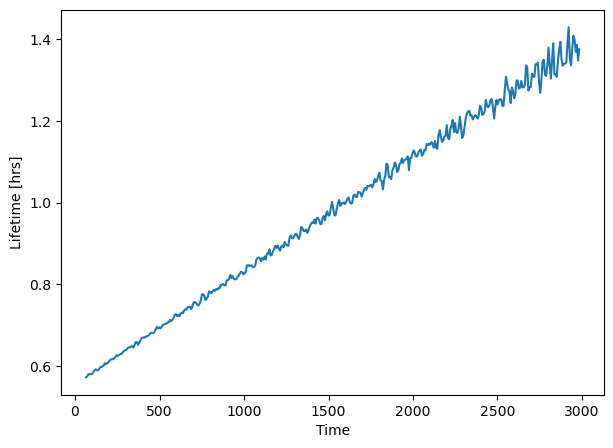

In [214]:
# Lifetime vs current goes up
fig, ax = plt.subplots(1,1,figsize = (7, 5))
ax.plot(df_data['t'], df_data['s'])
ax.set_xlabel('Time')
ax.set_ylabel('Lifetime [hrs]')

Text(0, 0.5, 'Lifetime [hrs]')

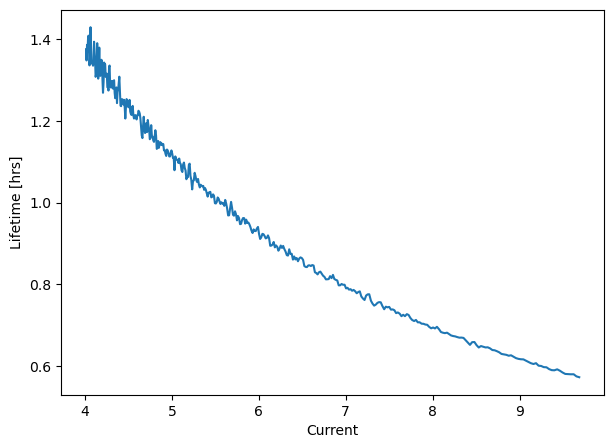

In [215]:
# Lifetime vs current goes down
fig, ax = plt.subplots(1,1,figsize = (7, 5))
ax.plot(df_data['avg_c'], df_data['s'])
ax.set_xlabel('Current')
ax.set_ylabel('Lifetime [hrs]')

Text(0, 0.5, 'Lifetime [hrs]')

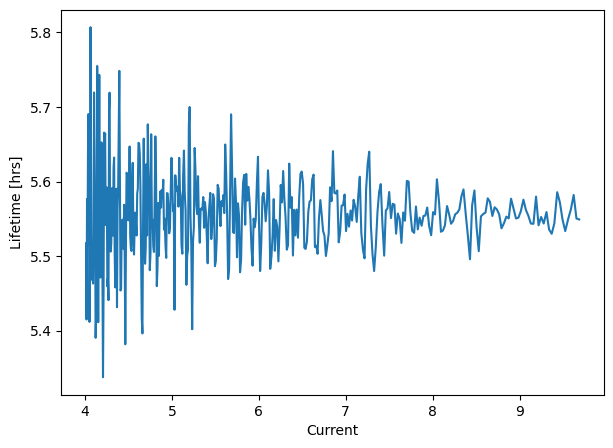

In [216]:
# Normalized lifetime vs current is flat
fig, ax = plt.subplots(1,1,figsize = (7, 5))
ax.plot(df_data['avg_c'], df_data['s']*(df_data['avg_c']))
ax.set_xlabel('Current')
ax.set_ylabel('Lifetime [hrs]')

In [217]:
# Normalization + lifetime simultaneous fitting
import scipy.integrate

# Exponential decay with extra y power parameter   
def ode(t, y, k, n):
    return -k * y**n

def intode(params, t, data):
    return scipy.integrate.solve_ivp(ode, (t[0], t[-1]), [data[0]], t_eval=t, args=params)

# Integrate ODE forward in time and compare to data
def residual(params, t, data):
    model = intode(params, t, data)
    return model.y[0] - data

# Fit parameters...we should probably use Bayesian inference but this is ok for now
result = scipy.optimize.least_squares(residual, x0=(0.001, 2), args=(x, y), bounds=[(1e-5,1e-2),(1,3)])
result

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 0.000e+00  2.541e-03 ... -3.863e-03 -3.094e-03]
           x: [ 5.113e-05  1.989e+00]
        cost: 0.020289313964243466
         jac: [[ 0.000e+00  0.000e+00]
               [-4.568e+01 -5.321e-03]
               ...
               [-4.645e+04 -4.200e+00]
               [-4.644e+04 -4.200e+00]]
        grad: [-4.562e-03 -2.600e-06]
  optimality: 0.004561674194563731
 active_mask: [0 0]
        nfev: 31
        njev: 24

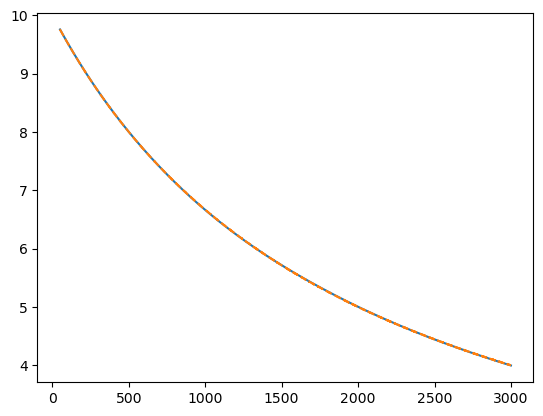

In [219]:
# Check fit
plt.plot(x, intode(result.x, x, y).y[0], label='y(t)')
plt.plot(x, y, '--')

In [227]:
J = result.jac
std = np.sqrt(np.diagonal(np.linalg.inv(J.T @ J) * (result.fun.T @ result.fun / (result.fun.size - result.x.size))))
print(result.x, std, 0.001/20)

[5.11344676e-05 1.98945395e+00] [1.37323611e-08 1.38003688e-04] 5e-05


In [229]:
# def simple_resample(n): 
#     return(np.random.randint(low = 0, high = n, size = n))

# def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
#     n = len(boot_pop)
#     resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
#     return resample_estimates

# df = pd.DataFrame({'x':x[xs], 'y':y[xs]})
# data_array = df.loc[:, ["x", "y"]].values
# theta_hat_sampling = bootstrap(data_array, educ_coeff)